# 3D_HOUSE PROJECT
### let's install and import dependancies


In [1]:
!pip install rasterio
!pip install numpy
!pip install matplotlib
!pip install geocoder
!pip install pyproj
!pip install open3d


In [2]:
import geocoder
import rasterio
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask
from pyproj import Proj, transform
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import open3d as o3d
import scipy.interpolate as sci


In [3]:
# les DTM représentes les données au sol en wallonie
# les DSM représentes les données au dessus du sol en wallonie

dtm_hainaut = rasterio.open('/home/leers/Project/turing4/DATASET/Wallonia/DTM 2013-2014/DTM_HAINAUT/RELIEF_HAINAUT_MNT_2013_2014.tif')
dsm_hainaut = rasterio.open('/home/leers/Project/turing4/DATASET/Wallonia/DSM 2013-2014/DSM_HAINAUT/RELIEF_HAINAUT_MNS_2013_2014.tif')

dtm_liege = rasterio.open('/home/leers/Project/turing4/DATASET/Wallonia/DTM 2013-2014/DTM_LIEGE/RELIEF_LIEGE_MNT_2013_2014.tif')
dsm_liege = rasterio.open('/home/leers/Project/turing4/DATASET/Wallonia/DSM 2013-2014/DSM_LIEGE/RELIEF_LIEGE_MNS_2013_2014.tif')

dtm_namur = rasterio.open('/home/leers/Project/turing4/DATASET/Wallonia/DTM 2013-2014/DTM_NAMUR/RELIEF_NAMUR_MNT_2013_2014.tif')
dsm_namur = rasterio.open('/home/leers/Project/turing4/DATASET/Wallonia/DSM 2013-2014/DSM_NAMUR/RELIEF_NAMUR_MNS_2013_2014.tif')

dtm_luxembourg = rasterio.open('/home/leers/Project/turing4/DATASET/Wallonia/DTM 2013-2014/DTM_LUXEMBOURG/RELIEF_LUXEMBOURG_MNT_2013_2014.tif')
dsm_luxembourg = rasterio.open('/home/leers/Project/turing4/DATASET/Wallonia/DSM 2013-2014/DSM_LUXEMBOURG/RELIEF_LUXEMBOURG_MNS_2013_2014.tif')

dtm_brabant = rasterio.open('/home/leers/Project/turing4/DATASET/Wallonia/DTM 2013-2014/DTM_BRABANT_WALLON/RELIEF_BRABANT_WALLON_MNT_2013_2014.tif')
dsm_brabant = rasterio.open('/home/leers/Project/turing4/DATASET/Wallonia/DSM 2013-2014/DSM_BRABANT_WALLON/RELIEF_BRABANT_WALLON_MNS_2013_2014.tif')

RASTERS = {
    'Hainaut':[dtm_hainaut, dsm_hainaut],
    'Liège':[dtm_liege, dsm_liege],
    'Namur':[dtm_namur, dsm_namur],
    'Luxembourg':[dtm_luxembourg, dsm_luxembourg],
    'Brabant-wallon':[dtm_brabant, dsm_brabant]
}



### Fonction de découpage pour le raster (tiff)

In [4]:
rayon = input("Rayon autour de la zone à découper (ex: 20) -> ")
rayon = int(rayon)

# raster = tiff, shape = geojson
def crop_raster(raster, shape):
    """fonction de découpage du tiff(raster) selon un géojson pour pouvoir l'afficher par la suite"""

    print(f'shape :{shape}')

    # Crop the raster
    out_image, out_transform = rasterio.mask.mask(raster, shapes=shape, all_touched=True, crop=True)
    out_meta = raster.meta
    print(f'out meta :{out_meta}')

    out_image = np.moveaxis(out_image.squeeze(), -1, 0)
    
    # Display the result BEFORE the resolution up
    plt.figure(figsize=(10, 14))
    plt.imshow(out_image)
    plt.colorbar(shrink=0.5)
    plt.show()

    # Up the resolution (here's * 16) of the cropped raster
    r = rayon * 2 + 1
    
    x_in=np.arange(0,r,1)
    y_in=np.arange(0,r,1)
    x_out= np.arange(0,r,0.25)
    y_out= np.arange(0,r,0.25)
    f = sci.RectBivariateSpline(x_in, y_in, out_image.squeeze())
    out_image = f(x_out, y_out)
    
    # Up all values for balance the Z axis later
    out_image = out_image * 3

    # Display the result AFTER the resolution up
    plt.figure(figsize=(10, 14))
    plt.imshow(out_image)
    plt.colorbar(shrink=0.5)
    plt.show()

    # Update the new tiff file metadata
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[0],
                 "width": out_image.shape[1],
                 "transform": out_transform })
                 #'nodata': no_data})

    return out_image, out_meta

Rayon autour de la zone à découper (ex: 20) -> 50


### création du geojson a partir d'une adresse entrée

In [5]:
post_code = input('Enter your postal code -> ')

# Geocoding d'une adresse via geocoder
g = geocoder.osm(f'belgium, {post_code}')
print(g.json)
county = g.json['county']

# Chargement des données correspondante à la région choisies
dtm, dsm = RASTERS[county]   


try:
    city = g.json['city']
except:
    city = g.json['town']
    
adress = input('Enter your adress (street + number) -> ')
print(f'Adresse complète : {adress}, {post_code} {city}')

g = geocoder.osm(f'{adress}, {post_code} {city}')
print(g.json)

coord = g.osm['x'],g.osm['y']
print(coord)

Enter your postal code -> 6220


INFO - 2020-10-30 11:32:17,954 - base - Requested https://nominatim.openstreetmap.org/search?q=belgium%2C+6220&format=jsonv2&addressdetails=1&limit=1


{'accuracy': 0.33499999999999996, 'address': 'Fleurus, Hainaut, Wallonie, 6220, Charleroi', 'bbox': {'northeast': [50.625332972982, 4.693068831763], 'southwest': [50.305332972982, 4.373068831763]}, 'confidence': 1, 'country_code': 'be', 'county': 'Hainaut', 'district': 'Fleurus', 'importance': 0.33499999999999996, 'lat': 50.46533297298165, 'lng': 4.5330688317629635, 'ok': True, 'place_id': 236593517, 'place_rank': 21, 'postal': '6220', 'quality': 'postcode', 'raw': {'place_id': 236593517, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'boundingbox': ['50.305332972982', '50.625332972982', '4.373068831763', '4.693068831763'], 'lat': '50.46533297298165', 'lon': '4.5330688317629635', 'display_name': 'Fleurus, Hainaut, Wallonie, 6220, Charleroi', 'place_rank': 21, 'category': 'place', 'type': 'postcode', 'importance': 0.33499999999999996, 'address': {'city_district': 'Fleurus', 'town': 'Fleurus', 'county': 'Hainaut', 'state': 'Wallonie', 'postcode': '62

INFO - 2020-10-30 11:32:21,850 - base - Requested https://nominatim.openstreetmap.org/search?q=ind+fleurus%2C+6220+Fleurus&format=jsonv2&addressdetails=1&limit=1


Adresse complète : ind fleurus, 6220 Fleurus
{'accuracy': 0.42099999999999993, 'address': 'IND Institut Notre-Dame, Rue de Bruxelles, Le Vieux Campinaire, Fleurus, Hainaut, Wallonie, 6220, België - Belgique - Belgien', 'allotments': 'Le Vieux Campinaire', 'bbox': {'northeast': [50.4859922, 4.5514573], 'southwest': [50.4858922, 4.5513573]}, 'confidence': 10, 'country': 'België - Belgique - Belgien', 'country_code': 'be', 'county': 'Hainaut', 'district': 'Fleurus', 'farm': 'Le Vieux Campinaire', 'hamlet': 'Le Vieux Campinaire', 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/education_school.p.20.png', 'importance': 0.42099999999999993, 'isolated_dwelling': 'Le Vieux Campinaire', 'lat': 50.4859422, 'lng': 4.5514073, 'ok': True, 'osm_id': 5233095907, 'osm_type': 'node', 'place_id': 62670993, 'place_rank': 30, 'postal': '6220', 'quality': 'school', 'raw': {'place_id': 62670993, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'no

In [6]:
# transformation des coordonées en lambert72

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:31370')

x1,y1 = coord
x2,y2 = transform(inProj,outProj,x1,y1)

print(x2,y2)

162962.71173172226 130586.37479873188


/home/leers/Project/turing4/3D_houses/venv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/leers/Project/turing4/3D_houses/venv/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/leers/Project/turing4/3D_houses/venv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<auth

In [7]:
# Fonction de découpage en carré autour d'un point
# r = rayon

def square(x,y,r):
  geojson = [{'type': 'Polygon', 'coordinates': [[(x - r, y - r), (x + r, y - r), (x + r, y + r), (x - r, y + r)]]}]
  return geojson

geojson = square(x2,y2,rayon)
print(geojson)


[{'type': 'Polygon', 'coordinates': [[(162912.71173172226, 130536.37479873188), (163012.71173172226, 130536.37479873188), (163012.71173172226, 130636.37479873188), (162912.71173172226, 130636.37479873188)]]}]


## Affichage du tiff découpé selon l'adresse entrées

shape :[{'type': 'Polygon', 'coordinates': [[(162912.71173172226, 130536.37479873188), (163012.71173172226, 130536.37479873188), (163012.71173172226, 130636.37479873188), (162912.71173172226, 130636.37479873188)]]}]
out meta :{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 126000, 'height': 98000, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 42000.0,
       0.0, -1.0, 167999.99999999927)}


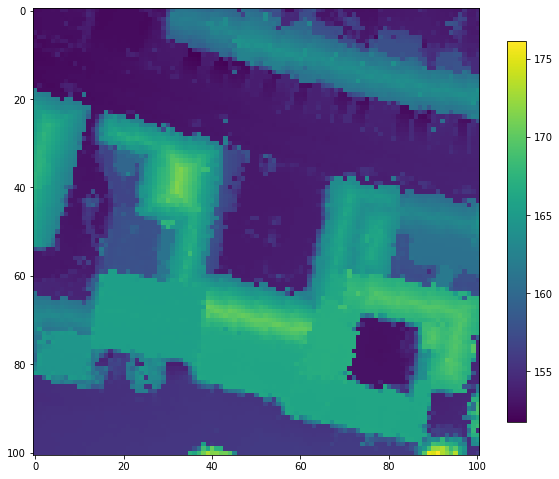

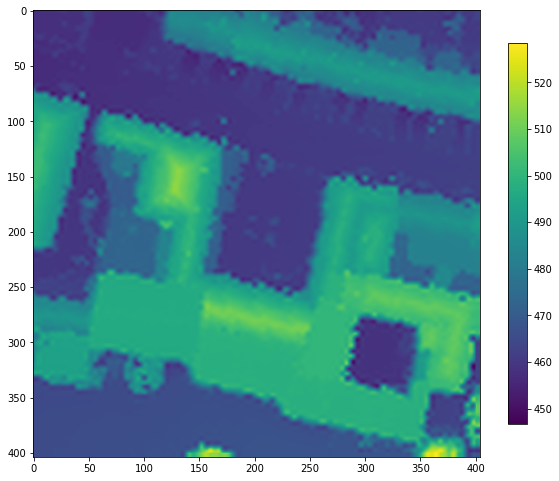

In [8]:
crop_result = crop_raster(dsm,geojson)

## Rendu 3d depuis le raster (tiff)

### Avec matplotlib ...

shape :[{'type': 'Polygon', 'coordinates': [[(162912.71173172226, 130536.37479873188), (163012.71173172226, 130536.37479873188), (163012.71173172226, 130636.37479873188), (162912.71173172226, 130636.37479873188)]]}]
out meta :{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 126000, 'height': 98000, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 42000.0,
       0.0, -1.0, 167999.99999999927)}


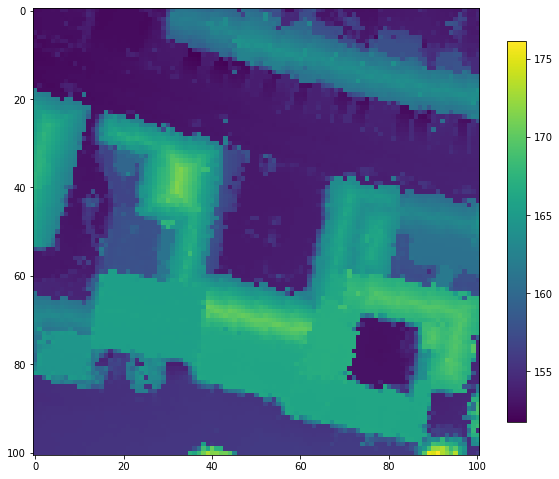

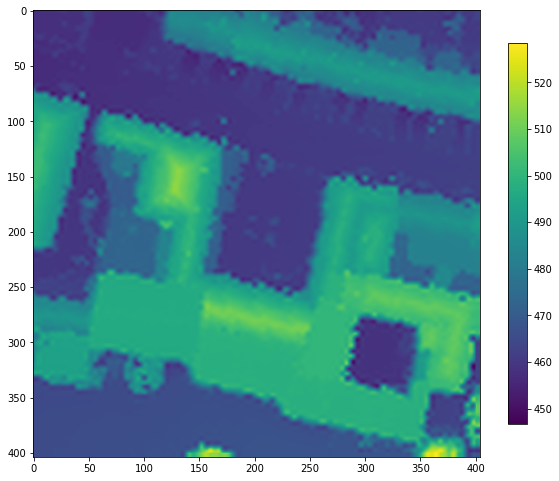

x.min: 0
x.max: 403
y.min: 0
y.max: 403
z.min: 446.7341541293214
z.max: 528.3599853515625


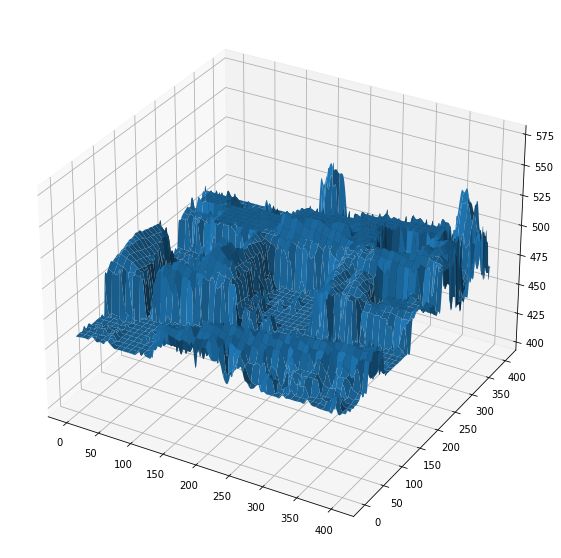

In [9]:
elevation_mask, _ = crop_raster(dsm, geojson)

z = elevation_mask
x, y = np.meshgrid(np.arange(z.shape[0]), np.arange(z.shape[1]))

print(f'x.min: {x.min()}')
print(f'x.max: {x.max()}')

print(f'y.min: {y.min()}')
print(f'y.max: {y.max()}')

print(f'z.min: {z.min()}')
print(f'z.max: {z.max()}')

z_min = z.min() - 50
z_max = z.max() + 50

# show hight map in 3d
fig = plt.figure(figsize=(28, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(z_min, z_max)
ax.plot_surface(x, y, z)

# ax.axis("off")
# ax.set_facecolor('black')
# ax.azim = 90
# ax.elev = 45

plt.show()

### Avec open3d ...

In [10]:
# class contenant diverse fonction permettant de traiter le raster avec des données x,y,z

class Raster2xyz(object):

    def __init__(self, verbose=True):
        pass

    def __geotrCoords(self, gtr, x, y):
        try:
            # gtr_x = gtr[0] + (x) * gtr[1] + (y) * gtr[2]
            # gtr_y = gtr[3] + (x) * gtr[4] + (y) * gtr[5]

            gtr_x = x
            gtr_y = y

            return (gtr_x, gtr_y)

        except Exception as err:
            self.__logger.error("Error getting geotransformed coordinates: {0}".format(err))

    def __getXyzData(self, raster_values, no_data):

        try:
            y, x = np.where(raster_values != no_data)
            data_vals = np.extract(raster_values != no_data, raster_values)

            return (x, y, data_vals)

        except Exception as err:
            print("Error getting XYZ data: {0}".format(err))

    def __buildXyzData(self, gtr_x, gtr_y, data_vals):

        try:
            data_dict = {
                "x": gtr_x,
                "y": gtr_y,
                "z": data_vals
            }

            return pd.DataFrame(data_dict)

        except Exception as err:
            print("Error building XYZ data: {0}".format(err))

    def __convert_meta(self, meta):
        return (meta[2], meta[0], meta[1], meta[5], meta[3], meta[4])

    def translate_from_cropped(self, crop_result, no_data=-9999):

        # Clean the received data
        raster, meta = crop_result
        meta = self.__convert_meta(meta['transform'])

        # Prepare the transformation
        x, y, data_vals = self.__getXyzData(raster, no_data)
        gtr_x, gtr_y = self.__geotrCoords(meta, x, y)

        return self.__buildXyzData(gtr_x, gtr_y, data_vals), (meta[0], meta[3])

# initialisation de la classe
raster2xyz = Raster2xyz()

In [11]:
# Conversion du raster en coordonées x,y,z
raster_cropped = raster2xyz.translate_from_cropped(crop_result)

# Récupération du dataframe
df = raster_cropped[0]

print(df.head(10))
print(df.shape)

   x  y           z
0  0  0  457.410004
1  1  0  457.357571
2  2  0  457.357049
3  3  0  457.398007
4  4  0  457.470016
5  5  0  457.562648
6  6  0  457.665473
7  7  0  457.768062
8  8  0  457.859985
9  9  0  457.933745
(163216, 3)


In [12]:
# transformation du dataframe en numpy array
np_array = df.to_numpy()
print(np_array)

# creation d'un nuage de points
pcd = o3d.geometry.PointCloud()

# ajouts de nos points dans le nuage
pcd.points = o3d.utility.Vector3dVector(np_array)

# visualisation 3d
o3d.visualization.draw_geometries([pcd])


[[  0.           0.         457.41000366]
 [  1.           0.         457.35757138]
 [  2.           0.         457.35704887]
 ...
 [401.         403.         468.33000183]
 [402.         403.         468.33000183]
 [403.         403.         468.33000183]]
